In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-02-04 18:14:44.273981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 18:14:44.816092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2024-02-04 18:14:44.816134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/

Num GPUs Available:  1


2024-02-04 18:14:45.970724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 18:14:45.973837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 18:14:45.973953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
dset = load_dataset('imagenet-1k', split='train', streaming=True, token=True)
dset.take(0)

/home/kris/.local/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for imagenet-1k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/imagenet-1k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


IterableDataset({
    features: ['image', 'label'],
    n_shards: 5
})

In [3]:
def show_image_at_index(dataset, index):
    # Iterate over the dataset until the desired index is reached
    for i, sample in enumerate(dataset):
        if i == index:
            img = sample['image']
            plt.imshow(img)
            plt.title(sample.get('label', 'No label'))  # Display the label if available
            plt.show()
            return 

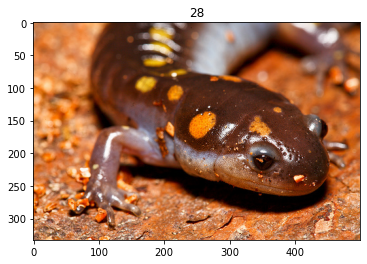

In [4]:
show_image_at_index(dset, 57)

In [5]:
import tensorflow as tf
import numpy as np
import tensorflow_io as tfio

def rgb_to_lab(tensor):
    return tfio.experimental.color.rgb_to_lab(tensor)

def split_lab_channels(lab_tensor):
    """Split the LAB tensor into L channel and AB channels."""
    L, A, B = tf.split(lab_tensor, [1, 1, 1], axis=-1)
    AB = tf.concat([A, B], axis=-1)  # Combine A and B channels
    return L, AB

def pil_image_to_tensor(image):
    """Convert a PIL Image to a TensorFlow tensor in LAB color space, ensuring it has 3 channels."""
    image_array = np.array(image)
    if image_array.ndim == 3 and image_array.shape[-1] == 3:
        tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        tensor = tensor / 255.0  # Normalize
        tensor = tf.image.resize(tensor, [224, 224])  # Resize
        lab_tensor = rgb_to_lab(tensor)  # Convert RGB to LAB
        L, AB = split_lab_channels(lab_tensor)

        # Normalize L channel to [0, 1]
        L = L / 100.0  # Assuming L channel was in the range [0, 100]
        
        # Normalize AB channels to [-1, 1]
        AB = AB / 128.0
        
        return L, AB
    else:
        return None

def generator_with_channel_check(dset):
    """Generator that yields L channel and AB channels separately."""
    for sample in dset:
        lab_tensor = pil_image_to_tensor(sample['image'])
        if lab_tensor is not None:
            yield lab_tensor

# Assuming `dset` is your dataset.
tf_dataset = tf.data.Dataset.from_generator(
    lambda: generator_with_channel_check(dset),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),  # L channel (now in [0, 1] range)
        tf.TensorSpec(shape=(224, 224, 2), dtype=tf.float32)   # AB channels
    )
)


2024-02-04 18:14:55.661211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 18:14:55.661630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 18:14:55.661779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 18:14:55.661881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [6]:
# Number of samples in your dataset
total_samples = 20000  # Adjust based on your actual dataset size
train_size = 15000  # Fixed training set size
val_size = 4900    # Fixed validation set size
test_size = 100   # Fixed test set size

tf_dataset = tf_dataset.take(total_samples)

# Assuming tf_dataset is your TensorFlow dataset with 100 samples
# Prepare the training dataset
train_dataset = tf_dataset.take(train_size)

# Prepare the validation dataset
val_dataset = tf_dataset.skip(train_size).take(val_size)

# Prepare the test dataset
test_dataset = list(tf_dataset.skip(train_size + val_size).take(test_size))

2024-02-04 18:14:58.217307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio  # Import TensorFlow IO for the lab_to_rgb function

def plot_l_ab_and_rgb_channels(L_tensor, AB_tensor):
    plt.figure(figsize=(18, 6))

    if isinstance(L_tensor, tf.Tensor):
        L_img = L_tensor.numpy().squeeze()  
    else:
        L_img = L_tensor.squeeze()

    if isinstance(AB_tensor, tf.Tensor):
        AB_img = AB_tensor.numpy()
    else:
        AB_img = AB_tensor
    
    # Scale L and AB channels back to [0, 100] and [-128, 127] respectively
    L_img = L_img * 100.0
    AB_img = (AB_img * 128.0).astype(np.int8)

    # Create an LAB image from L and AB channels
    lab_image = np.concatenate([L_img[..., np.newaxis], AB_img], axis=-1)
    lab_image_float = lab_image.astype(np.float32)

    # Use TensorFlow IO to convert LAB to RGB
    rgb_image = tfio.experimental.color.lab_to_rgb(lab_image_float)

    # Plot the L channel
    plt.subplot(1, 3, 1)  # Adjust to 1 row and 3 columns
    plt.imshow(L_img, cmap='gray')
    plt.title("L Channel")
    plt.axis('off')

    # Plot the AB channels properly
    plt.subplot(1, 3, 2)  # Adjust to 1 row and 3 columns
    ab_channels = np.concatenate([np.zeros_like(L_img[..., np.newaxis]), AB_img], axis=-1)
    plt.imshow(ab_channels, cmap='cool')
    plt.title("AB Channels")
    plt.axis('off')

    # Plot the LAB to RGB image
    plt.subplot(1, 3, 3)  # Adjust to 1 row and 3 columns
    plt.imshow(rgb_image)
    plt.title("LAB to RGB")
    plt.axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


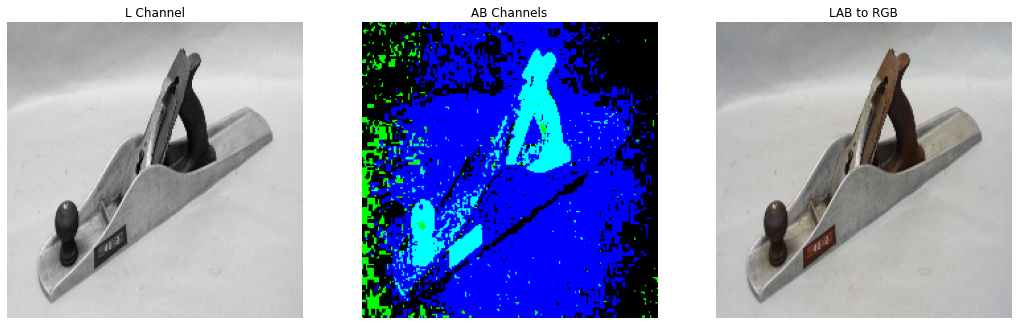

In [8]:
for L_channel, AB_channel in train_dataset.take(1): 
    plot_l_ab_and_rgb_channels(L_channel, AB_channel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


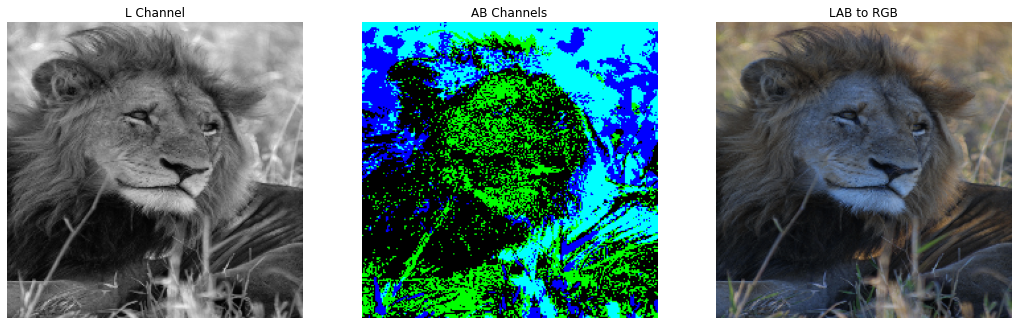

In [9]:
L_channel, AB_channel = test_dataset[1]
plot_l_ab_and_rgb_channels(L_channel, AB_channel)

In [10]:
from keras.applications import ResNet50

testResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Calculate starting index for the last 10 layers
start_index = len(testResNet.layers) - 10

# Loop through and display the last 10 layers
for i, layer in enumerate(testResNet.layers[start_index:], start=start_index):
    # Print layer index, name, and layer type
    print(f"Layer {i} : {layer.name} ({layer.__class__.__name__})")

    # Optionally, print output shape of each layer
    print(f"Output Shape: {layer.output_shape}\n")

Layer 165 : conv5_block3_1_conv (Conv2D)
Output Shape: (None, 7, 7, 512)

Layer 166 : conv5_block3_1_bn (BatchNormalization)
Output Shape: (None, 7, 7, 512)

Layer 167 : conv5_block3_1_relu (Activation)
Output Shape: (None, 7, 7, 512)

Layer 168 : conv5_block3_2_conv (Conv2D)
Output Shape: (None, 7, 7, 512)

Layer 169 : conv5_block3_2_bn (BatchNormalization)
Output Shape: (None, 7, 7, 512)

Layer 170 : conv5_block3_2_relu (Activation)
Output Shape: (None, 7, 7, 512)

Layer 171 : conv5_block3_3_conv (Conv2D)
Output Shape: (None, 7, 7, 2048)

Layer 172 : conv5_block3_3_bn (BatchNormalization)
Output Shape: (None, 7, 7, 2048)

Layer 173 : conv5_block3_add (Add)
Output Shape: (None, 7, 7, 2048)

Layer 174 : conv5_block3_out (Activation)
Output Shape: (None, 7, 7, 2048)



In [11]:
from keras import Sequential
from keras.layers import UpSampling2D, Conv2D, BatchNormalization, ReLU, InputLayer
from keras.applications import ResNet50
from keras import Input
from keras.optimizers import Adam

# Initialize the Sequential model
model = Sequential()

# Input layer for grayscale images
model.add(InputLayer(input_shape=(224, 224, 1)))

# Expand the 1-channel input to 3 channels
model.add(Conv2D(3, (1, 1), padding='same', activation='relu'))

# Add ResNet50 with the input shape now adjusted to 3 channels
# Note: We add ResNet50 as a layer directly without using the input_tensor parameter
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False  # Make ResNet layers non-trainable
model.add(resnet)

# Upsampling layers
model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(UpSampling2D(size=(2, 2)))  # Upscales to (None, 14, 14, 128)

model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(UpSampling2D(size=(2, 2)))  # Upscales to (None, 28, 28, 64)

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(UpSampling2D(size=(2, 2)))  # Upscales to (None, 56, 56, 32)

# Additional upsampling to match the target size
model.add(UpSampling2D(size=(2, 2)))  # Upscales to (None, 112, 112, 32)
model.add(UpSampling2D(size=(2, 2)))  # Finally upscales to (None, 224, 224, 32)

# Output layer for colorized image, adjusting to 2 channels
model.add(Conv2D(2, kernel_size=3, strides=1, padding='same', activation='tanh'))

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

model.compile(optimizer=Adam(learning_rate=0.01),
            loss='mean_squared_error',
            metrics=[PSNR, SSIM]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         2359424   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                      

In [12]:
batch_size = 32

# Train the model
history = model.fit(
    train_dataset.batch(batch_size),
    epochs=15,
    validation_data = val_dataset.batch(batch_size),
    verbose=1
)

Epoch 1/15


2024-02-04 18:18:46.287618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


469/469 [==============================] - 443s 937ms/step - loss: 0.0227 - PSNR: 18.9819 - SSIM: 0.1268 - val_loss: 0.0153 - val_PSNR: 19.7697 - val_SSIM: 0.1664
Epoch 2/15
469/469 [==============================] - 448s 954ms/step - loss: 0.0153 - PSNR: 20.0047 - SSIM: 0.1616 - val_loss: 0.0149 - val_PSNR: 20.0925 - val_SSIM: 0.1827
Epoch 3/15
469/469 [==============================] - 450s 959ms/step - loss: 0.0149 - PSNR: 20.2039 - SSIM: 0.1718 - val_loss: 0.0148 - val_PSNR: 20.1602 - val_SSIM: 0.1820
Epoch 4/15
469/469 [==============================] - 444s 947ms/step - loss: 0.0147 - PSNR: 20.2940 - SSIM: 0.1745 - val_loss: 0.0148 - val_PSNR: 20.1634 - val_SSIM: 0.1987
Epoch 5/15
469/469 [==============================] - 448s 954ms/step - loss: 0.0147 - PSNR: 20.3102 - SSIM: 0.1738 - val_loss: 0.0148 - val_PSNR: 20.1415 - val_SSIM: 0.1955
Epoch 6/15
469/469 [==============================] - 459s 979ms/step - loss: 0.0147 - PSNR: 20.3106 - SSIM: 0.1738 - val_loss: 0.0148 - val_

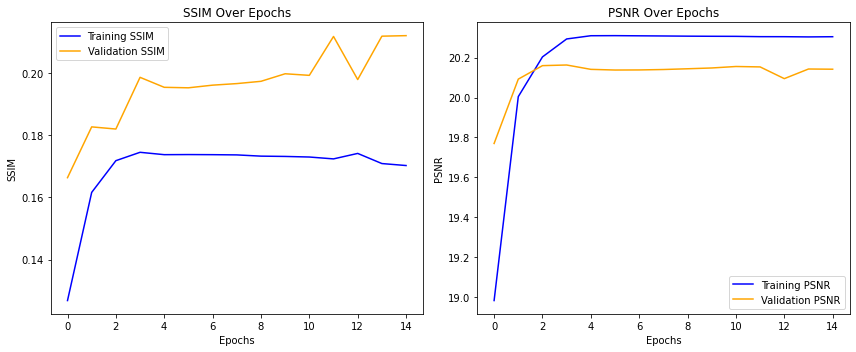

In [13]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot SSIM
ax1.plot(history.history['SSIM'], label='Training SSIM', color='blue')
ax1.plot(history.history['val_SSIM'], label='Validation SSIM', color='orange')
ax1.set_title('SSIM Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('SSIM')
ax1.legend()

# Plot PSNR
ax2.plot(history.history['PSNR'], label='Training PSNR', color='blue')
ax2.plot(history.history['val_PSNR'], label='Validation PSNR', color='orange')
ax2.set_title('PSNR Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('PSNR')
ax2.legend()

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [14]:
def test_prediction(test_dataset, index):
    L_channel, AB_channel = test_dataset[index] 
    print("Original")
    plot_l_ab_and_rgb_channels(L_channel, AB_channel)

    print("Predicted")
    L_channel_expanded = tf.expand_dims(L_channel, axis=0)
    AB_predicted = model.predict(L_channel_expanded)[0]
    plot_l_ab_and_rgb_channels(L_channel, AB_predicted)

In [15]:
L_channel, AB_channel = test_dataset[0] 
L_channel_expanded = tf.expand_dims(L_channel, axis=0)
AB_predicted = model.predict(L_channel_expanded)
AB_predicted

1/1 [==============================] - 1s 686ms/step


array([[[[0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         ...,
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315]],

        [[0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         ...,
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315]],

        [[0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         ...,
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315]],

        ...,

        [[0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         ...,
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.00290086, 0.07648315]],

        [[0.00290086, 0.07648315],
         [0.00290086, 0.07648315],
         [0.

In [ ]:
len(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


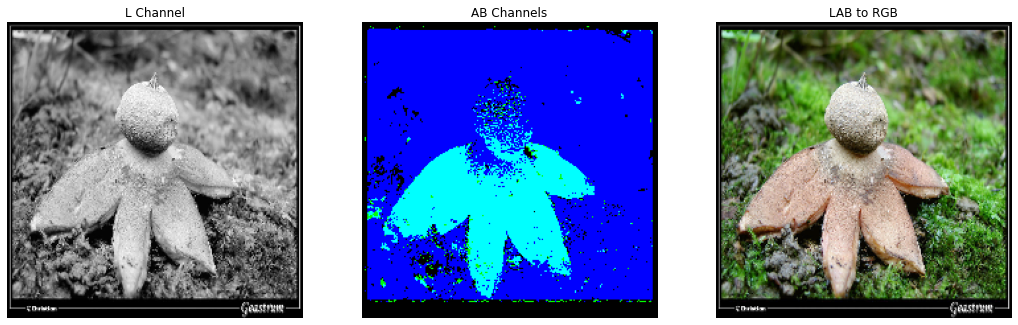

Predicted
1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


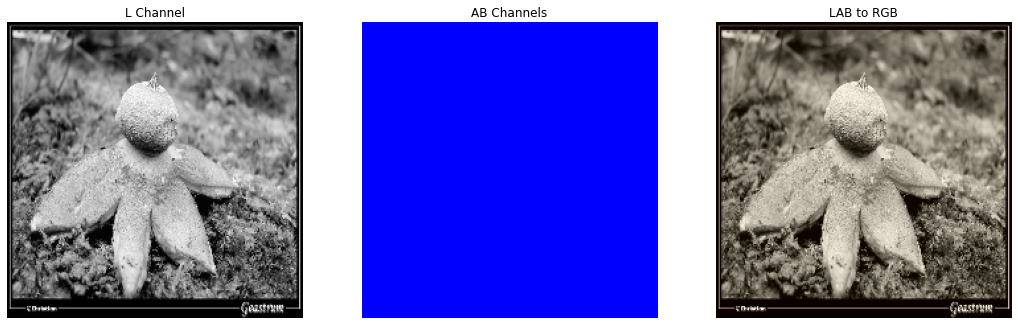

In [16]:
test_prediction(test_dataset, 22)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original


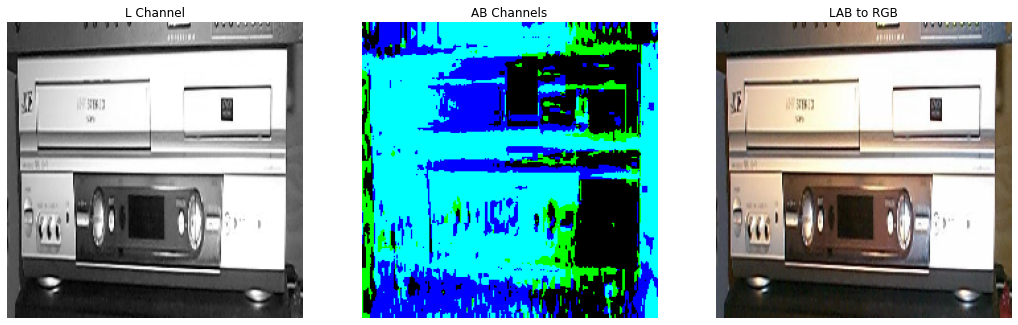

Predicted
1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


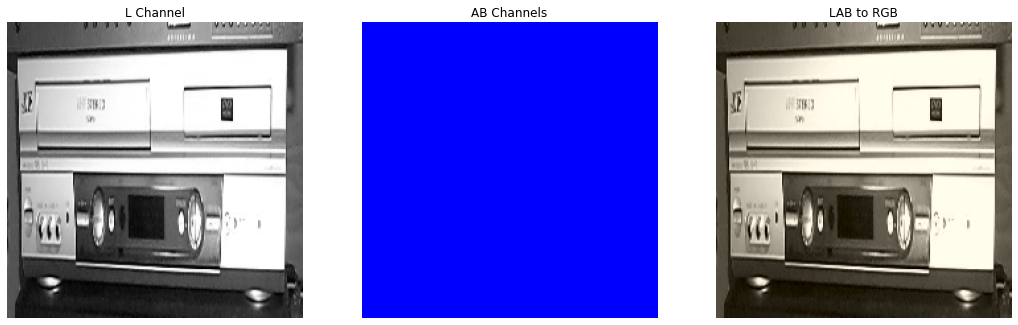

In [17]:
test_prediction(test_dataset, 29)